In [260]:
import pandas as pd
import importlib
import utilities as utils
import models as models
import os

activeMode= "develop"

# Reload utils library if changed
importlib.reload(utils)
# Reload models if changed
importlib.reload(models)

configuration_csv = pd.read_csv(f"./config/{activeMode}.csv", dtype=str, sep=";")
config = utils.configureParameters(configuration_csv)
max_grad_norm_str = str(config.max_grad_norm).replace(".","-")
print(f"Task: {config.task}")
print(f"Model path: {config.saved_model_path}")
print(f"Data path: {config.data_path}")
print(f"Tokenizer: {config.tokenizer}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.epochs}")
print(f"Learning rate: {config.learning_rate}")
print(f"Sequence length: {config.sequence_length}")
print(f"Training: {config.train_model}")
print(f"Num Threads: {config.num_threads}")
print(f"Num Sentences: {config.num_sentences}")
print(f"Max Norm: {config.max_grad_norm}")
print(f"Use GNN: {config.use_gnn}")
if(config.use_gnn == True):
    print(f"Num layers: {config.num_layers}")
    print(f"Num attention heads: {config.num_att_heads}")

Task: ner
Model path: bert-base-cased
Data path: ./data/ud/UD_English-GUM/
Tokenizer: bert-base-cased
Batch size: 2
Epochs: 2
Learning rate: 5e-05
Sequence length: 60
Training: True
Num Threads: 4
Num Sentences: 100
Max Norm: 0.0
Use GNN: True
Num layers: 3
Num attention heads: 2


In [261]:
# Export env vars to limit number of threads to use
num_threads = str(config.num_threads)
os.environ["OMP_NUM_THREADS"] = num_threads 
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads 
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

# Only use CPU, hide GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [262]:
from transformers import BertTokenizer, BertForMaskedLM, BertForTokenClassification, BertConfig, BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
#Import SummaryWriter for Tensorboard logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import (DataLoader, TensorDataset)
# Load Pytorch Geometric
from torch_geometric.data import Data
import torch_geometric.data as tg_data
import torch_geometric.loader as tg_loader
import torch_geometric.utils as tg_utils
import torch_geometric.nn as tg_nn
import evaluate
# Evaluation metrics for NER task
from seqeval.metrics import classification_report
# Support for IOBES style NER labels
from seqeval.scheme import IOBES
import numpy as np
# Progress bar
from tqdm import tqdm
# Easy file reading
import glob
import random
import pickle
import matplotlib.pyplot as plt
import math

In [263]:
PID = os.getpid()
PGID = os.getpgid(PID)
print(f"PID: {PID}, PGID: {PGID}")

PID: 456, PGID: 116


In [264]:
# Limit no. of threads used by Pytorch
torch.set_num_threads = int(num_threads)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [265]:
ner_tags_list = ['X','O','<unk>', 'B-CARDINAL', 'E-CARDINAL', 'S-PERSON', 'S-CARDINAL', 'S-PRODUCT', 'B-PRODUCT', 'I-PRODUCT', 'E-PRODUCT', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'E-WORK_OF_ART', 'B-PERSON', 'E-PERSON', 'S-GPE', 'B-DATE', 'I-DATE', 'E-DATE', 'S-ORDINAL', 'S-LANGUAGE', 'I-PERSON', 'S-EVENT', 'S-DATE', 'B-QUANTITY', 'E-QUANTITY', 'S-TIME', 'B-TIME', 'I-TIME', 'E-TIME', 'B-GPE', 'E-GPE', 'S-ORG', 'I-GPE', 'S-NORP', 'B-FAC', 'I-FAC', 'E-FAC', 'B-NORP', 'E-NORP', 'S-PERCENT', 'B-ORG', 'E-ORG', 'B-LANGUAGE', 'E-LANGUAGE', 'I-CARDINAL', 'I-ORG', 'S-WORK_OF_ART', 'I-QUANTITY', 'B-MONEY', 'I-MONEY', 'E-MONEY', 'B-LOC', 'E-LOC', 'I-LOC', 'B-PERCENT', 'I-PERCENT', 'E-PERCENT', 'S-LOC', 'S-FAC', 'B-EVENT', 'E-EVENT', 'I-EVENT', 'S-MONEY', 'B-LAW', 'I-LAW', 'E-LAW', 'I-NORP', 'I-LANGUAGE', 'S-LAW', 'S-QUANTITY', 'B-ORDINAL', 'I-ORDINAL', 'E-ORDINAL', '<START>', '<STOP>', "[CLS]", "[SEP]"]
num_ner_labels = len(ner_tags_list)

In [266]:
filepath_train_data = config.data_path + '**/*-train.txt'
filepath_validation_data = config.data_path + '**/*-dev.txt'
filepath_test_data = config.data_path + '**/*-test.txt'

filepath_train_syntrees = config.data_path + f'**/*-train-{config.tokenizer}.syntree'
filepath_validation_syntrees = config.data_path + f'**/*-dev-{config.tokenizer}.syntree'
filepath_test_syntrees = config.data_path + f'**/*-test-{config.tokenizer}.syntree'

filepath_train_ner_labels = config.data_path + f'**/*-train-orig.ner'
filepath_validation_ner_labels = config.data_path + f'**/*-dev-orig.ner'
filepath_test_ner_labels = config.data_path + f'**/*-test-orig.ner'

In [267]:
if (config.use_gnn == True):
    tensorboard_dir = f"./runs/{config.task}/synGNN/{config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}_GN{max_grad_norm_str}_TL_{config.num_layers}AttH_{config.num_att_heads}"
    tensorboard_dir = utils.createNumberedDir(tensorboard_dir)

    results_dir = f"./logs/{config.task}/Results/synGNN/{config.task}_{config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}_GN{max_grad_norm_str}_TL_{config.num_layers}AttH_{config.num_att_heads}"
    results_dir = utils.createNumberedDir(results_dir)
    if (activeMode == "prod"):
        trained_models_dir = f"./trained_models/{config.task}/synGNN/{config.task}_{config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}_GN{max_grad_norm_str}_TL_{config.num_layers}AttH_{config.num_att_heads}"
        trained_models_dir = utils.createNumberedDir(trained_models_dir)
else:
    tensorboard_dir = f"./runs/{config.task}/bert/{config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}_GN{max_grad_norm_str}"
    tensorboard_dir = utils.createNumberedDir(tensorboard_dir)

    results_dir = f"./logs/{config.task}/Results/bert/{config.task}_{config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}_GN{max_grad_norm_str}"
    results_dir = utils.createNumberedDir(results_dir)
    if (activeMode == "prod"):
        trained_models_dir = f"./trained_models/{config.task}/bert/{config.task}_{config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}_GN{max_grad_norm_str}"
        trained_models_dir = utils.createNumberedDir(trained_models_dir)


In [268]:
print(filepath_train_syntrees)

./data/ud/UD_English-GUM/**/*-train-bert-base-cased.syntree


In [269]:
tokenizer = BertTokenizer.from_pretrained(config.tokenizer)
if(config.task == 'mlm'):
    model = BertForMaskedLM.from_pretrained(config.saved_model_path)
if(config.task == 'ner'):
    BERTconfig = BertConfig.from_pretrained(config.saved_model_path, num_labels=num_ner_labels, tokenizer = tokenizer)
    if (config.use_gnn):
        #model = models.SynBertForNer.from_pretrained(config.saved_model_path, num_node_features=1, num_labels = num_ner_labels, num_att_heads = 2, num_layers = 3, from_tf = False, config = BERTconfig, low_cpu_mem_usage=True)
        model = models.SynBertForNer(bert_config = BERTconfig, num_node_features=768, num_labels = num_ner_labels, num_edge_attrs = 54, num_att_heads = config.num_att_heads, num_layers = config.num_layers)
    else:
        model = models.BertForNer.from_pretrained(config.saved_model_path, from_tf = False, config = BERTconfig)

In [270]:
device =  torch.device('cpu')
# Move model to device
model.to(device)

SynBertForNer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [271]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids, valid_ids=None, label_mask=None):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.valid_ids = valid_ids
        self.label_mask = label_mask,

In [272]:
def create_masked_inputs(inputs):
    """
    creates masked input embeddings and labels from tokenized text

    :param inputs: tokenized text
    :return: masked input embeddings and new column labels 
    """ 
    # Clone input ids (tokens) to create labels
    inputs['labels'] = inputs.input_ids.detach().clone()
    # create random array of floats with equal dimensions to input_ids tensor
    rand = torch.rand(inputs.input_ids.shape)
    # create mask array with 15% masked tokens
    mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
        (inputs.input_ids != 102) * (inputs.input_ids != 0)
    # Select indices of each nonzero (= selected) value as token to be masked
    selection = []

    for i in range(inputs.input_ids.shape[0]):
        selection.append(
            torch.flatten(mask_arr[i].nonzero()).tolist()
        )
    # Mask selected tokens: replace with [MASK] code 103 in tensor
    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, selection[i]] = 103
    
    return inputs

In [273]:
def create_ner_input_features(sentence_labels_list, label_list, max_seq_length, tokenizer):
    """Loads a list of sentences into a list of input features for the transformer
    
        :return: list of inpt features objects
    """

    # Map NER labels to indices
    # start with 1: 0 reserved for invalid labels e.g. subtoken labels
    label_map = {label : i for i, label in enumerate(label_list,0)}
    #label_map['X'] = 0

    features = []
    for (sentence_idx,sentence_label_pair) in enumerate(sentence_labels_list):
        # Tokenized text of sentence
        tokens = []
        # Token labels for sentence
        labels = []
        # Lists valid labels as 1 and labels to be ignored as 0 (e.g. for the labels for subword tokens which are not counting as separate labels for each token)
        valid = []
        # Mask for transformer indicating which tokens to ignore
        label_mask = []
        for word_label_pair in sentence_label_pair:
            token = tokenizer.tokenize(word_label_pair[0])
            tokens.extend(token)

            label_word = word_label_pair[1]
            for token_idx in range(len(token)):
                # Append label for first token in word, mark as valid
                if token_idx == 0:
                    labels.append(label_word)
                    valid.append(1)
                    label_mask.append(1)
                # Subword tokens: Mark as not valid
                else:
                    labels.append('X')
                    valid.append(0)
                    label_mask.append(1)
        # Sentence exceeds max sequence length: cut to sequence length
        if len(tokens) >= max_seq_length - 1:
            tokens = tokens[0:(max_seq_length - 2)]
            labels = labels[0:(max_seq_length - 2)]
            valid = valid[0:(max_seq_length - 2)]
            label_mask = label_mask[0:(max_seq_length - 2)]
        # Tokens with BERT [CLS] and [SEP] tokens
        ntokens = []
        # Segment ids for BERT
        segment_ids = []
        # Label embedding ids for BERT
        label_ids = []
        # Start segment
        ntokens.append("[CLS]")
        segment_ids.append(0)
        # Add CLS token label for Bert
        label_ids.append(label_map["[CLS]"])
        # Mark as valid label
        valid.insert(0,1)
        label_mask.insert(0,1)

        # add sentence tokens and label ids
        for i, token in enumerate(tokens):
            ntokens.append(token)
            segment_ids.append(0)
            if len(labels) > i:
                label_ids.append(label_map[labels[i]])
        # End segment
        ntokens.append("[SEP]")
        segment_ids.append(0)

        # Add SEP end token label for Bert
        label_ids.append(label_map["[SEP]"])
        valid.append(1)
        label_mask.append(1)


        if(sentence_idx<2):
            print(ntokens)

        # Convert tokens to ids
        input_ids = tokenizer.convert_tokens_to_ids(ntokens)
        input_mask = [1] * len(input_ids)
        
        # Pad sentence to sequence length
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        # Pad labels to sequence length
        while len(label_ids) < max_seq_length:
            label_ids.append(0)
            label_mask.append(0)
            valid.append(1)
        
        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        assert len(valid) == max_seq_length
        assert len(label_mask) == max_seq_length

        features.append(
        InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_ids=label_ids,
                        valid_ids=valid,
                        label_mask=label_mask
                        ))
    return features


In [274]:
class MlmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [275]:
class SynGNNDataset(torch.utils.data.Dataset):
    def __init__(self, features, syntax_graphs,sentence_graph_idx_maps):

        self.features = features
        self.syntax_graphs = syntax_graphs
        self.sentence_graph_idx_maps = sentence_graph_idx_maps

    def __getitem__(self, idx):
        data = self.syntax_graphs[idx]
        if(self.features is not None):
            features = self.features[idx]
            return features, data, self.sentence_graph_idx_maps[idx]
        else:
            return data, self.sentence_graph_idx_maps[idx]
        
    def __len__(self):
        return len(self.syntax_graphs)

In [276]:
def syngnn_data_collate_function(data):

    # Get all Bert input feature objects
    input_features = list(zip(*data))[0]
    # Get all input ids
    input_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.input_ids,input_features)),dtype=torch.long))

    # Get all input masks
    input_masks = torch.squeeze(torch.tensor(list(map(lambda x:x.input_mask,input_features)),dtype=torch.long))

    # Get all label ids
    label_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.label_ids,input_features)),dtype=torch.long))

    # Get all valid ids
    valid_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.valid_ids,input_features)),dtype=torch.long))

    # Get all label masks
    label_masks = torch.squeeze(torch.tensor(list(map(lambda x:x.label_mask,input_features)),dtype=torch.long))

    # Get all segment ids
    segment_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.segment_ids,input_features)),dtype=torch.long))

    # Get all Pytorch Geom Data objects
    pyg_data = list(zip(*data))[1]
    #pyg_data = tg_data.Batch.from_data_list(pyg_data)

    # Get all sentence_graph_idx_maps
    sentence_graph_idx_maps = list(zip(*data))[2]


    return input_ids, input_masks, label_ids, valid_ids, label_masks, segment_ids, pyg_data, sentence_graph_idx_maps

In [277]:
def train_ud_tokenizer(tokenizer, tokenizer_name):
    tokenizer_path = "./tokenizers/" + tokenizer_name 
    special_tokens = [
  "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
    ]
    # 30,522 vocab is BERT's default vocab size, feel free to tweak
    vocab_size = 30_522
    # Load data
    text = []
    for ud_file in glob.iglob(config.data_path + '**/UD_English-Pronouns/en_*.txt', recursive=True):

        ud_file = os.path.abspath(ud_file)
        filename = os.path.basename(ud_file)
        print(filename, flush = True)
        tokenizer.train(files=ud_file, vocab_size=vocab_size, special_tokens=special_tokens)
    # make the directory if not already there
    if not os.path.isdir(tokenizer_path):
        os.mkdir(tokenizer_path)
    # save the tokenizer  
    tokenizer.save_model(tokenizer_path)

In [278]:
def load_sentences_from_files(filepath, seq_length=None):
    """
    Load sentences from files.

    :param filepath: path to files (supports glob regex)
    :param seq_length: BERT sequence length. Must be provided when SynGNN is used instead of vanilla Bert. SynGNN only supports sentences up to seq_length, others are discarded
    :return: list of sentences
    """ 
    sentences = []
    for ud_file in sorted(glob.iglob(filepath, recursive=True)):

        ud_file = os.path.abspath(ud_file)
        filename = os.path.basename(ud_file)
        print(filename, flush = True)
        with open(ud_file, 'r') as fp:
            sentences_temp = fp.read().split('\n')
            if (seq_length != None):
                for sentence in sentences_temp:
                    if(len(sentence) <= seq_length):
                        sentences.extend(sentence)
            else:
                sentences.extend(fp.read().split('\n'))
    return sentences
        


In [279]:
def load_ner_labels_from_files(filepath, num_sentences=0, excluded_idx_list=None):
    """
    Load sentences from files.

    :param filepath: path to files (supports glob regex)
    :return: list of NER labels per sentence
    """ 
    all_token_label_pairs = []
    for ud_file in sorted(glob.iglob(filepath, recursive=True)):
        sentences = []
        ud_file = os.path.abspath(ud_file)
        filename = os.path.basename(ud_file)
        print(filename, flush = True)
        with open(ud_file, 'r') as fp:
            if (config.num_sentences == 0):
                # Split labels file by sentences
                sentences = fp.read().split('\n')
            else:
                sentences = fp.read().split('\n')[0:num_sentences]
        # Split sentences by tokens
        token_labels = [x.split("\t") for x in sentences]
        # Remove empty line at end of sentence
        [x.remove('') for x in token_labels]

        if (excluded_idx_list != None):
                       
            token_labels = [x for idx, x in enumerate(token_labels) if idx not in excluded_idx_list]
            
        # Split token and NER tags
        token_labels = [list(map(lambda x:x.split(" ") ,tag_token)) for tag_token in token_labels]
        tokens = [x[0] for idx, x in enumerate(token_labels)] 

        all_token_label_pairs.extend(token_labels)

    return all_token_label_pairs

In [280]:
def load_syntaxgraphs_from_files(filepath, seq_length=None, num_sentences=0):
    r"""
    Load binary syntax tree files (*.syntree).
    Args:
        filepath: path to files (supports glob regex)
        return: list of pytorch geometric syntax graphs per file and list of sentence token to graph node mappings
    """ 
    all_syntrees = []
    all_sentence_to_graph_maps = []
    for syntree_file in sorted(glob.iglob(filepath, recursive=True)):   
        syntree_file = os.path.abspath(syntree_file)
        filename = os.path.basename(syntree_file)
        print(f"Loading syntax graphs: from file {filename}", flush=True)
        with open(syntree_file, 'rb') as fp:
            if (config.num_sentences == 0):
                file_graphs_and_maps = pd.read_pickle(fp)
            else:
                file_graphs_and_maps = pd.read_pickle(fp)[0:num_sentences]

            # Create new list where graph nodes <= seq_length
            excluded_idx_list = []
            file_graphs_and_maps_seq = []

            for idx, graph_map_pair in enumerate(file_graphs_and_maps):
                if graph_map_pair[0].x.shape[0]-1>seq_length:
                    excluded_idx_list.append(idx)
                else:
                    file_graphs_and_maps_seq.append(graph_map_pair)
            #excluded_idx_list = [ idx for idx, graph_map_pair in enumerate(file_graphs_and_maps) if graph_map_pair[0].x.shape[0]-1>seq_length]
            #file_graphs_and_maps = [ graph_map_pair for graph_map_pair in enumerate file_graphs_and_maps if graph_map_pair[0].x.shape[0]-1<=seq_length]

            syntree_list = [graph_map_pair[0] for graph_map_pair in file_graphs_and_maps_seq]
            sentence_to_graph_map_list = [graph_map_pair[1] for graph_map_pair in file_graphs_and_maps_seq]
            all_syntrees.extend(syntree_list)
            all_sentence_to_graph_maps.extend(sentence_to_graph_map_list)
    print("Example syntax graphs:")
    print(all_syntrees[0:2])
    print(all_sentence_to_graph_maps[0:2])
    return all_syntrees, all_sentence_to_graph_maps, excluded_idx_list

In [281]:
#gnn_layer = models.SynGNNLayer(dim_in=1, dim_hdn = 5, dim_out = num_ner_labels, num_heads = 2)
#syngnn_model = models.SynGNN(gnn_layer, num_layers = 2)
#syngnn_model.to(device)

In [282]:
#syntrees_test, sentence_to_graph_maps_test = load_syntaxgraphs_from_files(filepath_test_syntrees)
#syntree_dataset = SynGNNDataset(syntrees_test, sentence_to_graph_maps_test)

In [283]:
#print(syntrees_test[0])
#print(sentence_to_graph_maps_test[0])

In [284]:

#num_node_features = syntrees_test[1].num_node_features
#num_edge_features = syntrees_test[1].num_edge_features
#syntree_test_loader = tg_loader.DataLoader(syntrees_test, batch_size=config.batch_size, shuffle=True)
#syntree_test_loader = DataLoader(syntree_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=syngnn_data_collate_function)


In [285]:
"""model.eval()
 # setup loop with TQDM and dataloader
with torch.no_grad():
    loop = tqdm(syntree_test_loader, leave=True, mininterval=40,maxinterval=120)
    for batch in loop:
        # pull all tensor batches required for training
        if (config.task == 'ner'):
            #batch.to(device)
            print(batch)
            pyg_data, sentence_graph_idx_maps = batch
            logits = syngnn_model(pyg_data.x, pyg_data.edge_index, pyg_data.batch)"""

"model.eval()\n # setup loop with TQDM and dataloader\nwith torch.no_grad():\n    loop = tqdm(syntree_test_loader, leave=True, mininterval=40,maxinterval=120)\n    for batch in loop:\n        # pull all tensor batches required for training\n        if (config.task == 'ner'):\n            #batch.to(device)\n            print(batch)\n            pyg_data, sentence_graph_idx_maps = batch\n            logits = syngnn_model(pyg_data.x, pyg_data.edge_index, pyg_data.batch)"

In [286]:
"""
# Print example of tokenized text
sentences = []
for ud_file in glob.iglob(config.data_path + '**/UD_English-Atiien_*.txt', recursive=True):

    ud_file = os.path.abspath(ud_file)
    filename = os.path.basename(ud_file)
    print(filename, flush = True)
    with open(ud_file, 'r') as fp:
        sentences.extend(fp.read().split('\n'))
count = 0
for sentence in sentences:
    # Tokenize data
    inputs = tokenizer(sentence, return_tensors='pt', max_length=config.sequence_length, truncation=True, padding='max_length')
    inputs = create_masked_inputs(inputs)

    # Create dataset from tokenized data
    dataset = SyntransDataset(inputs)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
    if(count==1):
        print(inputs['input_ids'])
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        print(tokens)
        print(inputs['labels'])
        break
    count=count+1"""

"\n# Print example of tokenized text\nsentences = []\nfor ud_file in glob.iglob(config.data_path + '**/UD_English-Atiien_*.txt', recursive=True):\n\n    ud_file = os.path.abspath(ud_file)\n    filename = os.path.basename(ud_file)\n    print(filename, flush = True)\n    with open(ud_file, 'r') as fp:\n        sentences.extend(fp.read().split('\n'))\ncount = 0\nfor sentence in sentences:\n    # Tokenize data\n    inputs = tokenizer(sentence, return_tensors='pt', max_length=config.sequence_length, truncation=True, padding='max_length')\n    inputs = create_masked_inputs(inputs)\n\n    # Create dataset from tokenized data\n    dataset = SyntransDataset(inputs)\n    loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=True)\n    if(count==1):\n        print(inputs['input_ids'])\n        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])\n        print(tokens)\n        print(inputs['labels'])\n        break\n    count=count+1"

In [287]:
def getMaxSequenceLength(sentences, cutoff_limit_percent=0.9999):
    """
    Calculate maximum sequence length for given data.
    param sentences: list of sentences
    param cutoff_limit_percent: percentage of all samples to accommodate with the max sequence length.
    returns: max sequence length which encompasses cutoff_limit_percent of all data samples
    """
    # Get number of tokens per sentence        
    max_sentence_tokens = 0
    sentence_tokens = {}
    print(f"Amount of samples: {len(sentences)}")
    # Tokenize data
    for sentence in sentences:

        inputs = tokenizer(sentence, return_tensors='pt')
        
        token_count = inputs.input_ids.size(dim=1)
        sentence_tokens[inputs.input_ids.size(dim=1)] = sentence_tokens.get(token_count,0) + 1
        if(token_count > max_sentence_tokens): 
            max_sentence_tokens = token_count
            
    no_tokens = 0
    # Calulate number of samples which should have a sequence length smaller than max_sequence_length
    cutoff = cutoff_limit_percent * len(sentences)
    max_sequence_length = 0
    print(max_sentence_tokens)
    for i in sorted(sentence_tokens):
        # print((i, sentence_tokens[i]), end=" ")
        if(no_tokens <= cutoff):
            no_tokens = no_tokens + sentence_tokens[i]
            max_sequence_length = i

    print(f"Max sequence length: {max_sequence_length} with {cutoff_limit_percent}% of samples smaller")
    return max_sequence_length

In [288]:
def createDataloader(filepath, filepath_syntrees = None, shuffle_data=False):

        # Load syntax graphs and create dataset
        if(config.use_gnn and filepath_syntrees != None):
            syntax_graphs, sentence_to_graph_idx_maps, excluded_idx_list = load_syntaxgraphs_from_files(filepath_syntrees, config.sequence_length, config.num_sentences)
        # Load NER labels
        if(config.task == 'ner'):
            print(f"Loading NER labels from {filepath}")
            # Load NER labels
            sentence_labels_list = load_ner_labels_from_files(filepath, config.num_sentences, excluded_idx_list)
            num_sentences = len(sentence_labels_list)
            num_batches = math.ceil(num_sentences / config.batch_size)
            print(f"{num_sentences} sentences, {num_batches} batches of size {config.batch_size}")
            print(f"Example of NER labels: {sentence_labels_list[0:2]}")

            features = create_ner_input_features(sentence_labels_list, ner_tags_list, config.sequence_length, tokenizer)
            all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
            all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
            all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
            all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)
            all_valid_ids = torch.tensor([f.valid_ids for f in features], dtype=torch.long)
            all_lmask_ids = torch.tensor([f.label_mask for f in features], dtype=torch.long)
            
            data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids,all_valid_ids,all_lmask_ids)
            #print(data.__sizeof__())

            # Print control example of InputFeatures
            print("Control example of InputFeatures")
            print(f"Input Ids: {str(features[1].input_ids)}")
            print(f"Input Mask: {str(features[1].input_mask)}")
            print(f"Label Ids: {str(features[1].label_ids)}")
            print(f"Valid Ids: {str(features[1].valid_ids)}")
            print(f"Label Mask: {str(features[1].label_mask)}")
            print(f"Segment Ids: {str(features[1].segment_ids)}")


        if(config.task == 'mlm'):
            # Load data
            sentences = load_sentences_from_files(filepath)
            # Tokenize data
            inputs = tokenizer(sentences, return_tensors='pt', max_length=config.sequence_length, truncation=True, padding='max_length')
            inputs = create_masked_inputs(inputs)

            # Create dataset from tokenized data
            data = MlmDataset(inputs)
        
        # Create dataset
        if(config.use_gnn and filepath_syntrees != None):
            syngnn_dataset = SynGNNDataset(features, syntax_graphs, sentence_to_graph_idx_maps)

            print(f"Syngnn dataset size: {syngnn_dataset.__len__()}")

            loader = DataLoader(syngnn_dataset, batch_size=config.batch_size, shuffle=shuffle_data, collate_fn=syngnn_data_collate_function)
        else:
            loader = DataLoader(data, batch_size=config.batch_size, shuffle=shuffle_data)
        return loader

In [289]:
def loadTrainData():
    print("Loading Training Data")
    if(config.task == 'ner'):
        if(config.use_gnn):
            return createDataloader(filepath_train_ner_labels, filepath_train_syntrees, shuffle_data=True)
        else:
            return createDataloader(filepath_train_ner_labels, shuffle_data=True)
    if(config.task == 'mlm'):
        if(config.use_gnn):
            return createDataloader(filepath_train_data, filepath_train_syntrees, shuffle_data=True)
        else:
            return createDataloader(filepath_train_data, shuffle_data=True)

In [290]:
def loadValidationData():
    print("Loading Validation Data")
    if(config.task == 'ner'):
        if(config.use_gnn):
            return createDataloader(filepath_validation_ner_labels, filepath_validation_syntrees, shuffle_data=True)
        else:
            return createDataloader(filepath_validation_ner_labels, shuffle_data=True)
    if(config.task == 'mlm'):
        return createDataloader(filepath_validation_data)

In [291]:
def loadTestData():
    print("Test Data")
    if(config.task == 'ner'):
        if(config.use_gnn):
            return createDataloader(filepath_test_ner_labels, filepath_test_syntrees, shuffle_data=False)
        else:
            return createDataloader(filepath_test_ner_labels, shuffle_data=False)
    if(config.task == 'mlm'):
        return createDataloader(filepath_test_data)

In [292]:
def trainModel(epoch, trainLoader, writer):
    # activate training mode
    model.train()

    from torch.optim import AdamW
    # initialize optimizer
    optim = AdamW(model.parameters(), lr=config.learning_rate)
    epoch_loss = 0
    # setup loop with TQDM and dataloader
    loop = tqdm(trainLoader, leave=True, mininterval=40,maxinterval=120)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        if (config.task == 'ner'):
            batch = tuple(t for t in batch)
            input_ids, input_mask, segment_ids, label_ids, valid_ids,l_mask = batch
            batch_loss, logits = model(input_ids, segment_ids, input_mask, label_ids,valid_ids,l_mask)
            batch_loss = loss.item()
        if (config.task == 'mlm'):
            # pull all tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # process
            outputs = model(input_ids, attention_mask=attention_mask,
                            labels=labels)
            # extract loss
            loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Train Epoch {epoch}')
        loop.set_postfix(loss=batch_loss)
        epoch_loss = epoch_loss + batch_loss
    # Calculate epoch loss
    epoch_loss = epoch_loss / len(trainLoader)
    # Print info to Tensorboard
    writer.add_scalar("Loss", epoch_loss, epoch)
    return epoch_loss, logits

In [293]:
def validateModel(epoch, validationLoader, writer):
    # activate eval mode
    model.eval()

    epoch_loss = 0
    # setup loop with TQDM and dataloader
    with torch.no_grad():
        loop = tqdm(validationLoader, leave=True, mininterval=40,maxinterval=120)
        for batch in loop:
            # pull all tensor batches required for training
            if (config.task == 'ner'):
                batch = tuple(t for t in batch)
                input_ids, input_mask, segment_ids, label_ids, valid_ids,l_mask = batch
                batch_loss, logits = model(input_ids, segment_ids, input_mask, label_ids,valid_ids,l_mask)
                batch_loss = batch_loss.item()
            if (config.task == 'mlm'):
                # pull all tensor batches required for training
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                # process
                batch_loss, logits = model(input_ids, attention_mask=attention_mask,
                                labels=labels)
                batch_loss = batch_loss.item()

            # print relevant info to progress bar
            loop.set_description(f'Validation Epoch {epoch}')

            loop.set_postfix(loss=batch_loss)
            epoch_loss = epoch_loss + batch_loss

            # Calculate epoch loss
            epoch_loss = epoch_loss / len(validationLoader)
            #print(epoch_loss)
            # Print info to Tensorboard
            writer.add_scalar("Loss", epoch_loss, epoch)
            return epoch_loss

In [294]:
from sys import stderr
def runModelGNN(data_loader, mode=None, writer = None, results_dir = None,  epoch = None):
    if(mode == 'Train'):
        model.train()
        from torch.optim import AdamW
        # initialize optimizer
        optim = AdamW(model.parameters(), lr=config.learning_rate)
    elif(mode == 'Test' or mode == 'Validation'):
        model.eval()
    else:
        stderr("Mode must be Train, Validation or Test")
        exit()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    y_true = []
    y_pred = []
    label_map = {i : label for i, label in enumerate(ner_tags_list,0)}

    references_all = []
    predictions_all = []
    references_roc_all = []
    predictions_roc_all = []

    if(config.task == 'mlm'):
        # Setup loop with TQDM and dataloader
        loop = tqdm(data_loader, leave=True, mininterval=20,maxinterval=120)
        for batch in loop:
    
            # Pull all tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).tolist()

            softmax = nn.Softmax(dim = -1)
            if (mode == 'Test' or mode == 'Validation'):
                with torch.no_grad():
                    predictions = model(input_ids)
            if(mode == 'Train'):
                # initialize calculated gradients (from prev step)
                optim.zero_grad()
                predictions = model(input_ids)
            predictions = predictions['logits']
            predictions_sm = softmax(predictions)

            # Change type to double to prevent floating point rounding errors
            predictions = predictions.type(torch.float64)
            predictions_sm = softmax(predictions)

            # Get index of argmax
            y = torch.topk(predictions, k=1, dim = 2)[1].squeeze()
            y = y.tolist()
                
            recall_metric = evaluate.load('recall')
            precision_metric = evaluate.load('precision')
            f1_metric = evaluate.load('f1')
            roc_auc_metric = evaluate.load("roc_auc", "multiclass")

            # Go through all samples in batch and add to computation batch
            for idx, pred_batch in enumerate(y):
                references_all.extend(labels[idx])
                predictions_all.extend(pred_batch)
            
            # Calculate ROC (TODO)
            #for batch_idx, pred_batch in enumerate(predictions_sm):
            #    predictions_roc_all.extend(pred_batch.tolist())
            #    references_roc_all.extend(labels[batch_idx])
            #    #roc_auc_metric.add_batch(references=labels[batch_idx], prediction_scores = pred_batch.tolist())
            #    break
            #break

        numberOfBatches = len(loop)
        # List all possible labels
        labels = np.arange(tokenizer.vocab_size)
        with open(results_dir +"results.txt", "w") as output:
            print(f"Results: {config.tokenizer}, Train={config.train_model} {config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}", file = output)
            output.write("macro averaging\n")
            output.write(str(recall_metric.compute(references = references_all, predictions = predictions_all, average = 'macro')))
            output.write("\n")
            output.write(str(precision_metric.compute(references = references_all, predictions = predictions_all, average = 'macro', zero_division = 0)))
            output.write("\n")
            output.write(str(f1_metric.compute( references = references_all, predictions = predictions_all, average = 'macro')))
            output.write("\n")
            output.write(str(roc_auc_metric.compute( references = references_roc_all, prediction_scores = predictions_roc_all, average = 'macro', multi_class = 'ovo', labels = labels, max_fpr = 1.0)))
            output.write("\n")
            output.write("weighted averaging\n")
            output.write(str(recall_metric.compute( references = references_all, predictions = predictions_all, average = 'weighted')))
            output.write("\n")
            output.write(str(precision_metric.compute( references = references_all, predictions = predictions_all, average = 'weighted', zero_division = 0)))
            output.write("\n")
            output.write(str(f1_metric.compute( references = references_all, predictions = predictions_all, average = 'weighted')))
            output.write("\n")
            output.write(str(roc_auc_metric.compute( references = references_roc_all, prediction_scores = predictions_roc_all, average = 'weighted', multi_class = 'ovo', labels = labels, max_fpr = 1.0)))
            output.close()
    
    if (config.task == 'ner'):

        sep_token_id = int(ner_tags_list.index("[SEP]"))
        cls_token_id = int(ner_tags_list.index("[CLS]"))
        unk_token_id = int(ner_tags_list.index("<unk>"))
        O_token_id = int(ner_tags_list.index("O"))

        special_token_predictions = 0
        O_token_predictions = 0
        ner_token_predictions = 0
        epoch_loss = 0
        # setup loop with TQDM and dataloader
        loop = tqdm(data_loader, leave=True, mininterval=20,maxinterval=120)
        # Loop over all batches
        for batch in loop:
            batch = tuple(t for t in batch)
            if (config.use_gnn):
                input_ids, input_masks, label_ids, valid_ids, label_mask, segment_ids, pyg_data, sentence_graph_idx_maps = batch
            else:
                input_ids, input_masks, segment_ids, label_ids, valid_ids,l_mask = batch

            if(mode == 'Train'):
                # initialize gradients for batch to zero
                optim.zero_grad()
                if (config.use_gnn):
                    loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids,syntax_graphs=pyg_data, sentence_graph_idx_maps=sentence_graph_idx_maps)
                else:
                    loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids)
                # calculate loss for every parameter that needs grad update
                loss.backward()
                if (config.max_grad_norm):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                # update parameters
                optim.step()
            elif(mode == 'Validation'):
                with torch.no_grad():
                    if (config.use_gnn):
                        loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids,syntax_graphs=pyg_data, sentence_graph_idx_maps=sentence_graph_idx_maps)
                    else:
                        loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids)
            elif(mode == 'Test'):
                if (config.use_gnn):
                     logits = model(input_ids=input_ids, token_type_ids=segment_ids,attention_mask=input_masks,valid_ids=valid_ids,attention_mask_label=label_mask, syntax_graphs=pyg_data, sentence_graph_idx_maps=sentence_graph_idx_maps)
                else:
                    logits = model(input_ids, segment_ids, input_masks,valid_ids=valid_ids,attention_mask_label=label_mask)

            if(mode == 'Validation' or mode == 'Train'):
                # print relevant info to progress bar
                loop.set_description(f'{mode} Epoch {epoch}')
                batch_loss = loss.item()
                loop.set_postfix(loss=batch_loss)
                epoch_loss = epoch_loss + batch_loss
            
            #print(f"Logits{logits}")
            softmax = nn.Softmax(dim=1)

            # Get highest NER label prediction for all sentences
            #print(f"Softmax:{softmax(logits)}")
            logits = torch.argmax(softmax(logits),dim=1)
            #print(f"Argmax: {logits}")
            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            input_masks = input_masks.to('cpu').numpy()

            # Go through true labels
            for label_list_idx, true_sentence_labels in enumerate(label_ids):
                y_true_temp = []
                y_pred_temp = []

                for label_idx, label_id in enumerate(true_sentence_labels):

                    # Skip 0 label
                    if label_id == 0:
                        continue

                    # Skip [CLS] label at sequence beginning
                    if label_id == cls_token_id:
                        continue

                    # Detect [SEP] label at sentence end and ignore [SEP] and all sequence padding
                    elif label_id == sep_token_id:
                        y_true.append(y_true_temp)
                        y_pred.append(y_pred_temp)
                        break
                    else:
                        # Predicted NER label is special token: count preds
                        #if (logits[label_list_idx][label_idx] == 0):
                        if (logits[label_list_idx] == 0):
                            special_token_predictions = special_token_predictions +1
                        # Predicted NER label is O: count preds
                        #elif (logits[label_list_idx][label_idx] == O_token_id):
                        elif (logits[label_list_idx] == O_token_id):
                            O_token_predictions = O_token_predictions +1
                        else:
                            ner_token_predictions = ner_token_predictions +1

                        # Append label and prediction to list
                        y_true_temp.append(label_map[label_id])
                        #y_pred_temp.append(label_map[logits[label_list_idx][label_idx]])
                        y_pred_temp.append(label_map[logits[label_list_idx]])

        if (mode == 'Train' or mode == 'Validation'):
            report = classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division = 0)
            # Calculate epoch loss
            epoch_loss = epoch_loss / len(data_loader)

            # Print info to Tensorboard
            writer.add_scalar("Loss", epoch_loss, epoch)
            macro_precision = report['macro avg']['precision']
            writer.add_scalar("macro_avg/precision", macro_precision, epoch)
            macro_recall = report['macro avg']['recall']
            writer.add_scalar("macro_avg/recall", macro_recall, epoch)
            macro_f1 = report['macro avg']['f1-score']
            writer.add_scalar("macro_avg/f1", macro_f1, epoch)

            weighted_precision = report['weighted avg']['precision']
            writer.add_scalar("weighted_avg/precision", weighted_precision, epoch)
            weighted_recall = report['weighted avg']['recall']
            writer.add_scalar("weighted_avg/recall", weighted_recall, epoch)
            weighted_f1 = report['weighted avg']['f1-score']
            writer.add_scalar("weighted_avg/f1", weighted_f1, epoch)
            print(f"O Token Predictions: {O_token_predictions}, NER token predictions: {ner_token_predictions}")
            print(f"loss: {epoch_loss} w prec: {weighted_precision} w recall: {weighted_recall} w f1: {weighted_f1}")
            return epoch_loss, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1

        else:
            print(y_true)
            print(y_pred)
            report = classification_report(y_true, y_pred, digits=4, output_dict=False)
            with open(results_dir +"results.txt", "w") as output:
                print("***** Test results *****")
                print(f"Task: {config.task}")
                print(f"Model path: {config.saved_model_path}")
                print(f"Data path: {config.data_path}")
                print(f"Tokenizer: {config.tokenizer}")
                print(f"Batch size: {config.batch_size}")
                print(f"Epochs: {config.epochs}")
                print(f"Learning rate: {config.learning_rate}")
                print(f"Sequence length: {config.sequence_length}")
                print(f"Training: {config.train_model}")
                print(f"Num Threads: {config.num_threads}")
                print(f"Num Sentences: {config.num_sentences}")
                print(f"Max Grad Norm: {config.max_grad_norm}")
                print(f"{report}\n Special token predictions: {special_token_predictions}")
                output.write(report)

In [295]:
from sys import stderr
def evaluateModel(data_loader, mode=None, writer = None, results_dir = None,  epoch = None):
    if(mode == 'Train'):
        model.train()
        from torch.optim import AdamW
        # initialize optimizer
        optim = AdamW(model.parameters(), lr=config.learning_rate)
    elif(mode == 'Test' or mode == 'Validation'):
        model.eval()
    else:
        stderr("Mode must be Train, Validation or Test")
        exit()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    y_true = []
    y_pred = []
    label_map = {i : label for i, label in enumerate(ner_tags_list,0)}

    references_all = []
    predictions_all = []
    references_roc_all = []
    predictions_roc_all = []

    if(config.task == 'mlm'):
        # Setup loop with TQDM and dataloader
        loop = tqdm(data_loader, leave=True, mininterval=20,maxinterval=120)
        for batch in loop:
    
            # Pull all tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).tolist()

            softmax = nn.Softmax(dim = -1)
            if (mode == 'Test' or mode == 'Validation'):
                with torch.no_grad():
                    predictions = model(input_ids)
            if(mode == 'Train'):
                # initialize calculated gradients (from prev step)
                optim.zero_grad()
                predictions = model(input_ids)
            predictions = predictions['logits']
            predictions_sm = softmax(predictions)

            # Change type to double to prevent floating point rounding errors
            predictions = predictions.type(torch.float64)
            predictions_sm = softmax(predictions)

            # Get index of argmax
            #y = np.argmax(predictions_sm, axis = -1)
            # y = y.tolist()
            y = torch.topk(predictions, k=1, dim = 2)[1].squeeze()
            y = y.tolist()
                

            recall_metric = evaluate.load('recall')
            precision_metric = evaluate.load('precision')
            f1_metric = evaluate.load('f1')
            roc_auc_metric = evaluate.load("roc_auc", "multiclass")


            # Go through all samples in batch and add to computation batch
            for idx, pred_batch in enumerate(y):
                references_all.extend(labels[idx])
                predictions_all.extend(pred_batch)
                #precision_metric.add_batch(references=labels[idx], predictions=pred_batch)
                #recall_metric.add_batch(references=labels[idx], predictions=pred_batch)
                #f1_metric.add_batch(references=labels[idx], predictions=pred_batch)
            
            # Calculate ROC
            for batch_idx, pred_batch in enumerate(predictions_sm):
                predictions_roc_all.extend(pred_batch.tolist())
                references_roc_all.extend(labels[batch_idx])
                #roc_auc_metric.add_batch(references=labels[batch_idx], prediction_scores = pred_batch.tolist())
                break
            break

        numberOfBatches = len(loop)
        # List all possible labels
        labels = np.arange(tokenizer.vocab_size)
        with open(results_dir +"results.txt", "w") as output:
            print(f"Results: {config.tokenizer}, Train={config.train_model} {config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}", file = output)
            output.write("macro averaging\n")
            output.write(str(recall_metric.compute(references = references_all, predictions = predictions_all, average = 'macro')))
            output.write("\n")
            output.write(str(precision_metric.compute(references = references_all, predictions = predictions_all, average = 'macro', zero_division = 0)))
            output.write("\n")
            output.write(str(f1_metric.compute( references = references_all, predictions = predictions_all, average = 'macro')))
            output.write("\n")
            output.write(str(roc_auc_metric.compute( references = references_roc_all, prediction_scores = predictions_roc_all, average = 'macro', multi_class = 'ovo', labels = labels, max_fpr = 1.0)))
            output.write("\n")
            output.write("weighted averaging\n")
            output.write(str(recall_metric.compute( references = references_all, predictions = predictions_all, average = 'weighted')))
            output.write("\n")
            output.write(str(precision_metric.compute( references = references_all, predictions = predictions_all, average = 'weighted', zero_division = 0)))
            output.write("\n")
            output.write(str(f1_metric.compute( references = references_all, predictions = predictions_all, average = 'weighted')))
            output.write("\n")
            output.write(str(roc_auc_metric.compute( references = references_roc_all, prediction_scores = predictions_roc_all, average = 'weighted', multi_class = 'ovo', labels = labels, max_fpr = 1.0)))
            output.close()
    
    if (config.task == 'ner'):

        sep_token_id = int(ner_tags_list.index("[SEP]"))
        cls_token_id = int(ner_tags_list.index("[CLS]"))
        unk_token_id = int(ner_tags_list.index("<unk>"))
        O_token_id = int(ner_tags_list.index("O"))

        special_token_predictions = 0
        O_token_predictions = 0
        ner_token_predictions = 0
        epoch_loss = 0
        # setup loop with TQDM and dataloader
        loop = tqdm(data_loader, leave=True, mininterval=20,maxinterval=120)
        # Loop over all batches
        for batch in loop:
            batch = tuple(t for t in batch)
            if (config.use_gnn):
                input_ids, input_masks, segment_ids, label_ids, valid_ids,l_mask, syntax_graphs, sentence_graph_idx_maps = batch

            else:
                input_ids, input_masks, segment_ids, label_ids, valid_ids,l_mask = batch
            if(mode == 'Train'):
                # initialize calculated gradients (from prev step)
                optim.zero_grad()
                loss, logits = model(input_ids, segment_ids, input_masks, label_ids,valid_ids,l_mask)
                # calculate loss for every parameter that needs grad update
                loss.backward()
                if (config.max_grad_norm):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                # update parameters
                optim.step()
            elif(mode == 'Validation'):
                with torch.no_grad():
                    loss, logits = model(input_ids, segment_ids, input_masks, label_ids,valid_ids,l_mask)
            elif(mode == 'Test'):
                if (config.use_gnn):
                     logits = model(input_ids=input_ids, token_type_ids=segment_ids,attention_mask=input_masks,valid_ids=valid_ids,attention_mask_label=l_mask, syntax_graphs=syntax_graphs, sentence_graph_idx_maps=sentence_graph_idx_maps)
                else:
                    logits = model(input_ids, segment_ids, input_masks,valid_ids=valid_ids,attention_mask_label=l_mask)

            if(mode == 'Validation' or mode == 'Train'):
                # print relevant info to progress bar
                loop.set_description(f'{mode} Epoch {epoch}')
                batch_loss = loss.item()
                loop.set_postfix(loss=batch_loss)
                epoch_loss = epoch_loss + batch_loss
            
            #print(f"Logits{logits}")
            softmax = nn.Softmax(dim=1)

            # Get highest NER label prediction for all sentences
            #print(f"Softmax:{softmax(logits)}")
            logits = torch.argmax(softmax(logits),dim=1)
            #print(f"Argmax: {logits}")
            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            input_masks = input_masks.to('cpu').numpy()

            # Go through true labels
            for label_list_idx, true_sentence_labels in enumerate(label_ids):
                y_true_temp = []
                y_pred_temp = []

                for label_idx, label_id in enumerate(true_sentence_labels):

                    # Skip 0 label
                    if label_id == 0:
                        continue

                    # Skip [CLS] label at sequence beginning
                    if label_id == cls_token_id:
                        continue

                    # Detect [SEP] label at sentence end and ignore [SEP] and all sequence padding
                    elif label_id == sep_token_id:
                        y_true.append(y_true_temp)
                        y_pred.append(y_pred_temp)
                        break
                    else:
                        # Predicted NER label is special token: count preds
                        if (logits[label_list_idx][label_idx] == 0):
                            special_token_predictions = special_token_predictions +1
                        # Predicted NER label is O: count preds
                        elif (logits[label_list_idx][label_idx] == O_token_id):
                            O_token_predictions = O_token_predictions +1
                        else:
                            ner_token_predictions = ner_token_predictions +1

                        # Append label and prediction to list
                        y_true_temp.append(label_map[label_id])
                        y_pred_temp.append(label_map[logits[label_list_idx][label_idx]])

        if (mode == 'Train' or mode == 'Validation'):
            print(f"True: {y_true[0:1]}, Predicted: {y_pred[0:1]}")
            report = classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division = 0)
            # Calculate epoch loss
            epoch_loss = epoch_loss / len(data_loader)

            # Print info to Tensorboard
            writer.add_scalar("Loss", epoch_loss, epoch)
            macro_precision = report['macro avg']['precision']
            writer.add_scalar("macro_avg/precision", macro_precision, epoch)
            macro_recall = report['macro avg']['recall']
            writer.add_scalar("macro_avg/recall", macro_recall, epoch)
            macro_f1 = report['macro avg']['f1-score']
            writer.add_scalar("macro_avg/f1", macro_f1, epoch)

            weighted_precision = report['weighted avg']['precision']
            writer.add_scalar("weighted_avg/precision", weighted_precision, epoch)
            weighted_recall = report['weighted avg']['recall']
            writer.add_scalar("weighted_avg/recall", weighted_recall, epoch)
            weighted_f1 = report['weighted avg']['f1-score']
            writer.add_scalar("weighted_avg/f1", weighted_f1, epoch)
            print(f"O Token Predictions: {O_token_predictions}, NER token predictions: {ner_token_predictions}")
            print(f"loss: {epoch_loss} w prec: {weighted_precision} w recall: {weighted_recall} w f1: {weighted_f1}")
            return epoch_loss, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1

        else:

            report = classification_report(y_true, y_pred, digits=4, output_dict=False)
            with open(results_dir +"results.txt", "w") as output:
                print("***** Test results *****")
                print(f"Task: {config.task}")
                print(f"Model path: {config.saved_model_path}")
                print(f"Data path: {config.data_path}")
                print(f"Tokenizer: {config.tokenizer}")
                print(f"Batch size: {config.batch_size}")
                print(f"Epochs: {config.epochs}")
                print(f"Learning rate: {config.learning_rate}")
                print(f"Sequence length: {config.sequence_length}")
                print(f"Training: {config.train_model}")
                print(f"Num Threads: {config.num_threads}")
                print(f"Num Sentences: {config.num_sentences}")
                print(f"Max Grad Norm: {config.max_grad_norm}")
                print(f"{report}\n Special token predictions: {special_token_predictions}")
                output.write(report)

Training model
Loading Training Data
Loading syntax graphs: from file en_gum-ud-train-bert-base-cased.syntree
Example syntax graphs:
[Data(x=[12, 768], edge_index=[2, 11], edge_attr=[11, 54]), Data(x=[9, 768], edge_index=[2, 8], edge_attr=[8, 54])]
[{0: 1, 1: 10, 2: 11, 3: 2, 4: 7, 5: 8, 6: 9, 7: 4, 8: 5, 9: 3, 10: 6}, {0: 1, 1: 4, 2: 5, 3: 3, 4: 2, 5: 6, 6: 7, 7: 8}]
Loading NER labels from ./data/ud/UD_English-GUM/**/*-train-orig.ner
en_gum-ud-train-orig.ner
94 sentences, 47 batches of size 2
Example of NER labels: [[['Aesthetic', 'O'], ['Appreciation', 'O'], ['and', 'O'], ['Spanish', 'S-NORP'], ['Art', 'O'], [':', 'O']], [['Insights', 'O'], ['from', 'O'], ['Eye-Tracking', 'O']]]
['[CLS]', 'A', '##est', '##hetic', 'A', '##pp', '##re', '##ciation', 'and', 'Spanish', 'Art', ':', '[SEP]']
['[CLS]', 'In', '##sight', '##s', 'from', 'Eye', '-', 'Track', '##ing', '[SEP]']
Control example of InputFeatures
Input Ids: [101, 1130, 18883, 1116, 1121, 9329, 118, 6563, 1158, 102, 0, 0, 0, 0, 0, 0,

Train Epoch 0: 100%|██████████| 47/47 [04:03<00:00,  5.18s/it, loss=0.826]
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


O Token Predictions: 968, NER token predictions: 1118
loss: 2.7574997005310466 w prec: 0.003496503496503497 w recall: 0.008547008547008548 w f1: 0.004962779156327542


Validation Epoch 0: 100%|██████████| 43/43 [03:24<00:00,  4.75s/it, loss=0.37] 


O Token Predictions: 1132, NER token predictions: 1105
loss: 1.0100928926190664 w prec: 0.0 w recall: 0.0 w f1: 0.0


Train Epoch 1: 100%|██████████| 47/47 [03:59<00:00,  5.09s/it, loss=0.293] 
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <unk> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


O Token Predictions: 1073, NER token predictions: 1013
loss: 0.8219040264474585 w prec: 0.004048582995951417 w recall: 0.008547008547008548 w f1: 0.005494505494505494


Validation Epoch 1: 100%|██████████| 43/43 [03:23<00:00,  4.74s/it, loss=2.14] 


O Token Predictions: 1115, NER token predictions: 1122
loss: 0.9336498570303584 w prec: 0.0 w recall: 0.0 w f1: 0.0


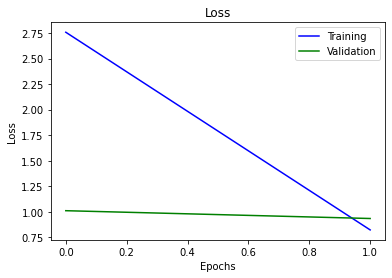

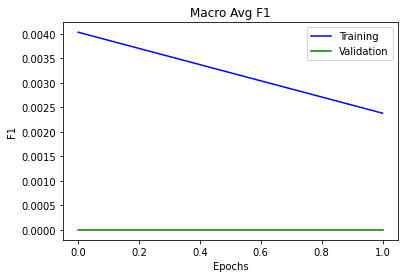

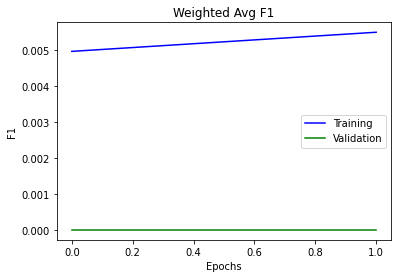

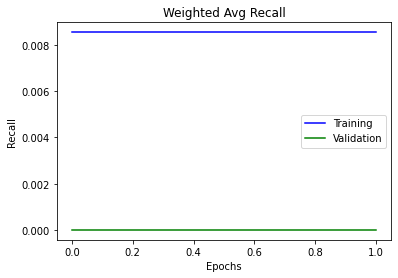

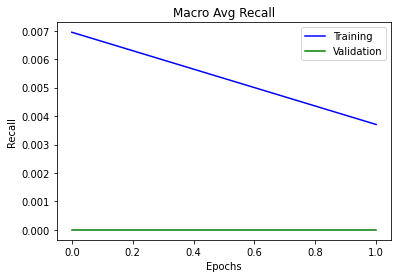

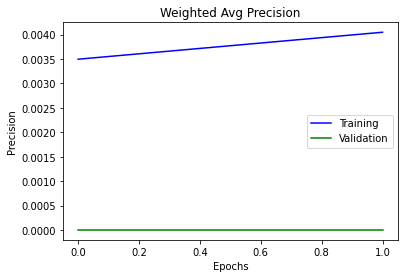

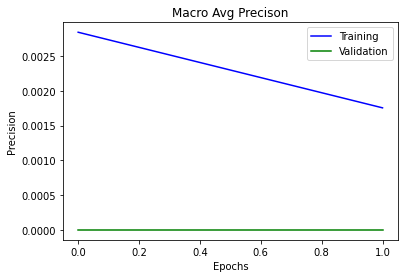

In [296]:
if (config.train_model):
    print("Training model", flush=True)

    trainLoader = loadTrainData()
    validationLoader = loadValidationData()

    epochs = config.epochs

    train_writer = SummaryWriter(log_dir=tensorboard_dir+"training")
    validation_writer = SummaryWriter(log_dir=tensorboard_dir+"validation")

    epoch_losses_train = []
    macro_precisions_train = []
    macro_recalls_train = []
    macro_f1s_train = []
    weighted_precisions_train = []
    weighted_recalls_train = []
    weighted_f1s_train = []

    epoch_losses_validation = []
    macro_precisions_val = []
    macro_recalls_val = []
    macro_f1s_val = []
    weighted_precisions_val = []
    weighted_recalls_val = []
    weighted_f1s_val = []

    for epoch in range(epochs):
        #epoch_losses_train.append(trainModel(epoch, trainLoader, train_writer))
        #epoch_losses_validation.append(validateModel(epoch, validationLoader, validation_writer))

        epoch_loss_train, macro_precision_train, macro_recall_train, macro_f1_train, weighted_precision_train, weighted_recall_train, weighted_f1_train = runModelGNN(trainLoader, mode = 'Train', writer = train_writer, results_dir = results_dir, epoch=epoch)
        epoch_losses_train.append(epoch_loss_train)
        macro_precisions_train.append(macro_precision_train)
        macro_recalls_train.append(macro_recall_train)
        macro_f1s_train.append(macro_f1_train)

        weighted_precisions_train.append(weighted_precision_train)
        weighted_recalls_train.append(weighted_recall_train)
        weighted_f1s_train.append(weighted_f1_train)

        epoch_loss_val, macro_precision_val, macro_recall_val, macro_f1_val, weighted_precision_val, weighted_recall_val, weighted_f1_val = runModelGNN(validationLoader, mode = 'Validation', writer = validation_writer, results_dir = results_dir, epoch=epoch)
        epoch_losses_validation.append(epoch_loss_val)
        macro_precisions_val.append(macro_precision_val)
        macro_recalls_val.append(macro_recall_val)
        macro_f1s_val.append(macro_f1_val)

        weighted_precisions_val.append(weighted_precision_val)
        weighted_recalls_val.append(weighted_recall_val)
        weighted_f1s_val.append(weighted_f1_val)


        if (activeMode == 'prod'):
            # Save model after each epoch
            model.save_pretrained(save_directory=trained_models_dir)
    
    train_writer.close()
    validation_writer.close()
    # Save epoch loss plots
    plt.figure()
    plt.plot(range(0,epochs), epoch_losses_train, 'b', label='Training')
    plt.plot(range(0,epochs), epoch_losses_validation, 'g', label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(results_dir +"/loss.png", facecolor='white', transparent=False)
    plt.show()


    # # Save macro f1 plot
    plt.figure()
    plt.plot(range(0,epochs), macro_f1s_train, 'b', label='Training')
    plt.plot(range(0,epochs), macro_f1s_val, 'g', label='Validation')
    plt.title('Macro Avg F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.savefig(results_dir +"/f1_macro.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save weighted f1 plot
    plt.figure()
    plt.plot(range(0,epochs), weighted_f1s_train, 'b', label='Training')
    plt.plot(range(0,epochs), weighted_f1s_val, 'g', label='Validation')
    plt.title('Weighted Avg F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.savefig(results_dir +"/f1_weighted.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save weighted recall plot
    plt.figure()
    plt.plot(range(0,epochs,1), weighted_recalls_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), weighted_recalls_val, 'g', label='Validation')
    plt.title('Weighted Avg Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig(results_dir +"/recall_weighted.png", facecolor='white', transparent=False)
    # #plt.show()


    # # Save macro recall plot
    plt.figure()
    plt.plot(range(0,epochs,1), macro_recalls_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), macro_recalls_val, 'g', label='Validation')
    plt.title('Macro Avg Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig(results_dir +"/recall_macro.png", facecolor='white', transparent=False)
    # #plt.show()

    #  # Save weighted precision plot
    plt.figure()
    plt.plot(range(0,epochs,1), weighted_precisions_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), weighted_precisions_val, 'g', label='Validation')
    plt.title('Weighted Avg Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(results_dir +"/precision_weighted.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save macro precision plot
    plt.figure()
    plt.plot(range(0,epochs,1), macro_precisions_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), macro_precisions_val, 'g', label='Validation')
    plt.title('Macro Avg Precison')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(results_dir +"/precision_macro.png", facecolor='white', transparent=False)
    #plt.show()

# Model evaluation

In [ ]:
print("Model evaluation\n", flush = True)

In [ ]:
test_loader = loadTestData()
runModelGNN(test_loader, mode = 'Test', results_dir=results_dir)

In [ ]:
print("Finished evaluation")

In [ ]:
#confusion_matrix = metrics.confusion_matrix(references_all, predictions_all, labels=labels)
#print(confusion_matrix)
#disp = metrics.ConfusionMatrixDisplay(references_all, predictions_all, labels=labels)
#disp.plot()